In [1]:
import requests
from requests.exceptions import ConnectionError
from time import sleep
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from pprint import pprint
from openpyxl import load_workbook
from openpyxl import Workbook
import yaml
import gspread

In [2]:
import httplib2
import argparse
from googleapiclient import discovery
from googleapiclient.discovery import build
from oauth2client import client
from oauth2client import tools
from oauth2client import file
from oauth2client.file import Storage
import google.oauth2.credentials
import google_auth_oauthlib.flow
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
import calendar

In [4]:
from matplotlib import pyplot as plt

#### Google Analytics Reporting API v4 auth

In [5]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
api_name = 'analyticsreporting'
api_version = 'v4'
client_secret = (r'.../Downloads/analytics-client-secret-grants.json')
token_name = 'cwa_' + api_name + '.json'

In [6]:
# -------- SCOPES --------

SCOPES = ['https://spreadsheets.google.com/feeds',  
          'https://www.googleapis.com/auth/drive']

# -------- CREDENTIALS --------
CREDENTIALS = ServiceAccountCredentials.from_json_keyfile_name(
    r'.../Downloads/google-sheets-service-key.json', SCOPES)

# -------- service --------
http = CREDENTIALS.authorize(httplib2.Http())
discoveryUrl = ('https://sheets.googleapis.com/$discovery/rest?version=v4')
service = discovery.build('sheets', 'v4', http = http, discoveryServiceUrl=discoveryUrl)

# -------- gspread --------
gc = gspread.authorize(CREDENTIALS)
sh = gc.open('CWA budgets reporting')

spreadsheet_id = '1_pgxcPDlFlCupgp2pmFdLBoXJQAymgpfIz0AVV7XshY'

#### Token refreshing

In [7]:
config = json.load(open(token_name))
client_id = config['client_id']
client_secret = config['client_secret']
refresh_token = config['refresh_token']
access_token = config['access_token']

def update_token(client_id, client_secret, refresh_token):
        
    url_token = 'https://accounts.google.com/o/oauth2/token'
    params = {
        'client_id': client_id, 
        'client_secret': client_secret, 
        'refresh_token': refresh_token, 
        'grant_type': 'refresh_token'
    }
    
    r = requests.post(url_token, data=params)
    print('The token will expire at {}'.format(datetime.today() + 
                                     timedelta(hours=1)))
    return r.json()['access_token']

In [8]:
token = update_token(client_id, client_secret, refresh_token)

The token will expire at 2023-02-05 12:07:18.959533


#### List (dict) of accounts

From the separate `json`/`yaml` file.

In [9]:
file_path = '.../Downloads/CWA_GAAccounts.yml'

In [10]:
account = {}

In [11]:
with open(file_path, 'r') as file:
    account = yaml.load(file, Loader=yaml.FullLoader)
file.close()

In [12]:
account

{'CWA': '71739892',
 'BYA': '50797641',
 'BHS': '108632486',
 'FAD': '60999447',
 'SNC': '20885361',
 'GRS': '101341505',
 'VLG': '192790089',
 'KEI': '213374250',
 'LD': '45256915',
 'ED': '196968921',
 'OAH': '220415367',
 'REG': '185868877',
 'UNI': '218779597',
 'AMT': '200982998',
 'HGG': '86629544',
 'SLG': '239506445',
 'ALM': '150019458',
 'SEL': '172697382',
 'NDI': '197441230',
 'ANR': '157428643',
 'INT': '248782937',
 'TNS': '13913347',
 'CLN': '250116451',
 'MTP': '147303555',
 'PRC': '254216575',
 'HVE': '261599315',
 'DVC': '261568276',
 'MUEX': '136367134',
 'MUEXSJ': '129237628',
 'GRM': '58998066',
 'BRR': '262521059',
 'CPA': '256481372',
 'EUM': '23459047',
 'BOX': '280682521',
 'TLF': '200909541',
 'SGD': '282256310'}

In [13]:
# -------- Auth data --------

headers = {'Authorization': 'Bearer ' + token}

#### Report dates

In [14]:
if datetime.now().day == 1:
    month = str(datetime.now().month - 1) # If today is the first day of the month - change month the previous one
else:
    month = str(datetime.now().month)

In [15]:
if datetime.now().month < 10: # If the month number is less than 10 - add 0 before the number
    month = '-0' + month
else:
    month = '-' + month

In [16]:
start_date = str(datetime.now().year) + month + '-01'
end_date = datetime.today().strftime('%Y-%m-%d') # Current day
start_date, end_date

('2023-02-01', '2023-02-05')

#### Analytics Reporting API v4 params & metrics

In [17]:
# -------- Request params --------

def reporting_api_v4_request(profile_id):
    url = 'https://analyticsreporting.googleapis.com/v4/reports:batchGet'
 
    metrics = [
        {'expression': 'ga:adCost'}, 
        {'expression': 'ga:adClicks'}, 
        {'expression': 'ga:CPC'}
    ]
    dimensions = [
        {'name': 'ga:source'}, 
        {'name': 'ga:medium'}
    ]
    filters = [{'filters': [
        {'dimensionName': 'ga:sourceMedium', 
         'operator': 'EXACT', 
         'expressions': ['google / cpc']}, 
        {'dimensionName': 'ga:sourceMedium', 
         'operator': 'EXACT', 
         'expressions': ['google / display']}
    ]}]
    
    # -------- Request body --------

    request = {
        'reportRequests': [
            {
                'viewId': profile_id,
                'dateRanges': [
                    {'startDate': start_date, 'endDate': end_date}
                ],
                'metrics': metrics,
                'dimensions': dimensions, 
                'dimensionFilterClauses': filters
            } 
        ]
    }
    
    # -------- Request --------

    r = requests.post(url, json=request, headers=headers)
    data = r.json()
    
    report = data['reports'][0]['data']['rows'][0]['metrics'][0]['values']
    
    return report

In [18]:
temp = pd.DataFrame()

print('Report for: {} - {}'.format(start_date, end_date)) # Dates period

# Clearing the cells that contain the data
service.spreadsheets().values().clear(spreadsheetId=spreadsheet_id, range='Sheet1!E2:K').execute()

for key, value in account.items():
    login = key
    profile_id = value
    
    i=2
    try:
        api_report = reporting_api_v4_request(profile_id)
        
        api_report.insert(0, start_date)
        api_report.insert(1, end_date)
        api_report.insert(2, login)
        
        body = {'values': [api_report]} # Adding of main data
        service.spreadsheets().values().append(spreadsheetId=spreadsheet_id, range='Sheet1!F'+str(i), 
                                               valueInputOption='USER_ENTERED', 
                                               body=body).execute()

        temp = temp.append([api_report], ignore_index=True)
        
        i+=1
        
    except: # Filling of empty strings
        temp = temp.append([[start_date, end_date, login]], ignore_index=True)
        
        body = {'values': [[start_date, end_date, login]]}
        service.spreadsheets().values().append(spreadsheetId=spreadsheet_id, range='Sheet1!F'+str(i), 
                                               valueInputOption='USER_ENTERED', 
                                               body=body).execute()
        continue
    print('{} added'.format(login))
print('Report created: https://docs.google.com/spreadsheets/d/1_pgxcPDlFlCupgp2pmFdLBoXJQAymgpfIz0AVV7XshY/edit?usp=sharing')

Report for: 2023-02-01 - 2023-02-05
CWA added
BYA added
BHS added
FAD added
SNC added
GRS added
VLG added
KEI added
LD added
ED added
OAH added
REG added
UNI added
AMT added
HGG added
SLG added
ALM added
SEL added
NDI added
ANR added
INT added
TNS added
CLN added
MTP added
PRC added
HVE added
DVC added
MUEX added
MUEXSJ added
GRM added
BRR added
CPA added
EUM added
BOX added
TLF added
SGD added
Report created: https://docs.google.com/spreadsheets/d/1_pgxcPDlFlCupgp2pmFdLBoXJQAymgpfIz0AVV7XshY/edit?usp=sharing


#### Getting the data about approved budgets for the each active client.

In [19]:
approved_budgets = service.spreadsheets().values().batchGet(
    spreadsheetId=spreadsheet_id, ranges='Sheet1!C2:C51').execute()['valueRanges'][0]['values']

approved_budgets = pd.DataFrame(approved_budgets)
approved_budgets.rename(columns={0: 'approved_budget'}, inplace=True)

In [20]:
temp = temp.rename(columns={0: 'start_date', 1: 'end_date', 2: 'name', 
                            3: 'ad_cost', 4: 'ad_clicks', 5: 'cpc'}).astype(
    {'ad_cost': float, 'ad_clicks': int, 'cpc': float}, 
    errors='ignore').round({'ad_cost': 2, 'cpc': 2})

temp = pd.concat([temp, approved_budgets], axis=1)

In [21]:
def str_to_int(row):
    i = row['approved_budget']
    if '$' or ',' in i:
        try:
            i = i.replace('$', '')
            i = i.replace(',', '')
            return float(i)
        except:
            return 0

In [22]:
temp['approved_budget'] = temp.apply(str_to_int, axis=1)

In [23]:
temp['spent_ratio'] = round((temp['ad_cost']/temp['approved_budget'])*100, 2)

In [24]:
temp

,start_date,end_date,name,ad_cost,ad_clicks,cpc,approved_budget,spent_ratio
0,2023-02-01,2023-02-05,CWA,57.15,7,8.16,500.0,11.43
1,2023-02-01,2023-02-05,BYA,488.25,130,3.76,4500.0,10.85
2,2023-02-01,2023-02-05,BHS,4598.44,4412,1.04,26500.0,17.35
3,2023-02-01,2023-02-05,FAD,605.67,154,3.93,7000.0,8.65
4,2023-02-01,2023-02-05,SNC,408.16,227,1.80,5000.0,8.16
5,2023-02-01,2023-02-05,GRS,513.86,178,2.89,4500.0,11.42
6,2023-02-01,2023-02-05,VLG,198.07,43,4.61,1500.0,13.20
7,2023-02-01,2023-02-05,KEI,396.17,115,3.44,4500.0,8.80
8,2023-02-01,2023-02-05,LD,455.16,151,3.01,3000.0,15.17
9,2023-02-01,2023-02-05,ED,143.55,688,0.21,2500.0,5.74


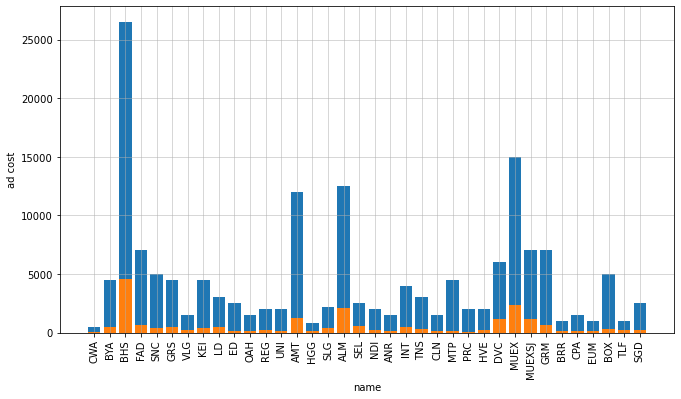

In [25]:
plt.figure(figsize=(11, 6))
plt.bar(temp.name, temp.approved_budget);
plt.bar(temp.name, temp.ad_cost);
plt.xlabel('name')
plt.ylabel('ad cost')
plt.xticks(rotation=90)
plt.grid(True, linewidth = 0.5)